## Best CNN Model for ASL Recognition (28 classes)
- 5 Convolutional Layers, 3 Pooling Layers, 1 Linear Layer, 1 Output Layer
- ReLU Activation Functions
- Batch normalization on all layers, dropout (p=0.4) on linear layers only
- Training batch size of 64
- Learning rate of 0.001
- Convolutional Kernel: 5x5
- Pooling kernel: 2x2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
import os
import cv2
from sklearn.model_selection import train_test_split
import random
import gc
import datetime
import sys

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load in raw dataset, run pre-processing and convert image data to tensors.
- Resize each image to 128x128 from 200x200
- Adjust brightness and contrast randomly, convert all images to grayscale
- Create horizontal flip of each image (1 new image)
- Apply two random rotations for original image and two random rotations for flipped image (4 new images)
- Total: 1 original image -> 6 processed images. So the original dataset size of 84000 turns to 504000

In [ ]:
#Data Pre-Processing -> Apply random contrast, saturation.  Flip horizontally once, then do 2 random rotations between -45 and 45 to flip and original (1 image becomes 6 images) (may take up to 10 to 15 minutes on slower machines)

from asl_alphabet import load_data

image_data, labels = load_data("archive/asl_alphabet_train/asl_alphabet_train")
print(f"Length of image_data array: {len(image_data)}")
print(f"Length of labels list: {len(labels)}")

RAM used to store image data: 15750 MB
Now loading in images from folder: A, time: 21:0
Now loading in images from folder: B, time: 21:0
Now loading in images from folder: C, time: 21:0
Now loading in images from folder: D, time: 21:1
Now loading in images from folder: E, time: 21:1
Now loading in images from folder: F, time: 21:1
Now loading in images from folder: G, time: 21:1
Now loading in images from folder: H, time: 21:1
Now loading in images from folder: I, time: 21:1
Now loading in images from folder: J, time: 21:1
Now loading in images from folder: K, time: 21:1
Now loading in images from folder: L, time: 21:1
Now loading in images from folder: M, time: 21:1
Now loading in images from folder: N, time: 21:2
Now loading in images from folder: nothing, time: 21:2
Now loading in images from folder: O, time: 21:2
Now loading in images from folder: P, time: 21:2
Now loading in images from folder: Q, time: 21:2
Now loading in images from folder: R, time: 21:2
Now loading in images fr

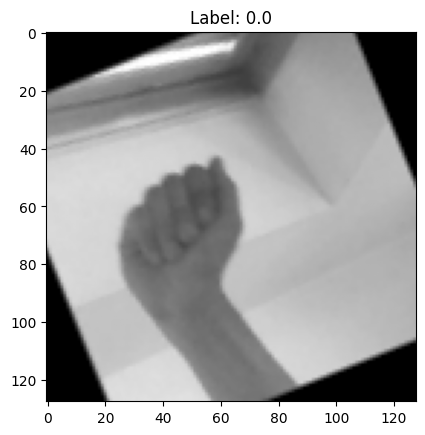

In [4]:
# Generate one image to ensure processing looks correct 
plt.imshow(image_data[2000].squeeze(), cmap='gray')
plt.title(f"Label: {labels[2000]}")
plt.show()

In [5]:
#ensure image data and labels are all float16
for i in range(len(image_data)):
    if image_data[i].dtype != "float16":
        print(image_data[i].dtype, i)

for i in range(len(labels)):
    if labels[i].dtype != "float16":
        print(labels[i].dtype, i)

#PyTorch requires color channels to be swapped for the image data
image_data = np.transpose(image_data, (0, 3, 1, 2))
print(image_data.shape)

#check the number of each label that was imported to make sure it is even
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

(504000, 1, 128, 128)


{np.float16(0.0): np.int64(18000),
 np.float16(1.0): np.int64(18000),
 np.float16(2.0): np.int64(18000),
 np.float16(3.0): np.int64(18000),
 np.float16(4.0): np.int64(18000),
 np.float16(5.0): np.int64(18000),
 np.float16(6.0): np.int64(18000),
 np.float16(7.0): np.int64(18000),
 np.float16(8.0): np.int64(18000),
 np.float16(9.0): np.int64(18000),
 np.float16(10.0): np.int64(18000),
 np.float16(11.0): np.int64(18000),
 np.float16(12.0): np.int64(18000),
 np.float16(13.0): np.int64(18000),
 np.float16(14.0): np.int64(18000),
 np.float16(15.0): np.int64(18000),
 np.float16(16.0): np.int64(18000),
 np.float16(17.0): np.int64(18000),
 np.float16(18.0): np.int64(18000),
 np.float16(19.0): np.int64(18000),
 np.float16(20.0): np.int64(18000),
 np.float16(21.0): np.int64(18000),
 np.float16(22.0): np.int64(18000),
 np.float16(23.0): np.int64(18000),
 np.float16(24.0): np.int64(18000),
 np.float16(25.0): np.int64(18000),
 np.float16(26.0): np.int64(18000),
 np.float16(27.0): np.int64(18000)}

In [6]:
#convert image_data and labels to tensors
image_data_tens = []

for i in image_data:
  t = torch.from_numpy(i)
  image_data_tens.append(t)

#Loop to transform numpy data to tensor
label_tens = []

for i in labels:
  t = torch.from_numpy(np.array(i))
  label_tens.append(t)

print(type(label_tens[1]))
print(type(image_data_tens[0]))

del image_data #can delete this now that we have tensors, but need to keep labels for reference in calculating accuracy

<class 'torch.Tensor'>
<class 'torch.Tensor'>


## Prepare to Run the Model

Setup training and test splits

In [7]:
#Split dataset into training and test sets
x_Train, x_Test, y_Train, y_Test = train_test_split(image_data_tens, label_tens, random_state=42, shuffle=True, test_size=0.2)
unique, counts = np.unique(y_Train, return_counts=True)
print("train data contains: " + str(dict(zip(unique, counts))))
unique, counts = np.unique(y_Test, return_counts=True)
print("test data contains: "+ str(dict(zip(unique, counts))))
print("Train set samples: "+ str(len(y_Train)))
print("Test set samples: "+ str(len(y_Test)))

train_data = list(zip(x_Train, y_Train))
test_data = list(zip(x_Test, y_Test))

train data contains: {np.float16(0.0): np.int64(14429), np.float16(1.0): np.int64(14434), np.float16(2.0): np.int64(14340), np.float16(3.0): np.int64(14453), np.float16(4.0): np.int64(14336), np.float16(5.0): np.int64(14419), np.float16(6.0): np.int64(14406), np.float16(7.0): np.int64(14385), np.float16(8.0): np.int64(14370), np.float16(9.0): np.int64(14326), np.float16(10.0): np.int64(14420), np.float16(11.0): np.int64(14335), np.float16(12.0): np.int64(14455), np.float16(13.0): np.int64(14322), np.float16(14.0): np.int64(14468), np.float16(15.0): np.int64(14462), np.float16(16.0): np.int64(14325), np.float16(17.0): np.int64(14440), np.float16(18.0): np.int64(14448), np.float16(19.0): np.int64(14512), np.float16(20.0): np.int64(14415), np.float16(21.0): np.int64(14371), np.float16(22.0): np.int64(14424), np.float16(23.0): np.int64(14393), np.float16(24.0): np.int64(14453), np.float16(25.0): np.int64(14379), np.float16(26.0): np.int64(14287), np.float16(27.0): np.int64(14393)}
test dat

In [8]:
del image_data_tens, label_tens

Model Hyperparameters

In [9]:
n_epochs = 50
train_batch_size = 64 
test_batch_size = 128
learning_rate = 0.001
conv_kernel_size = 5
pool_kernel_size = 2

Load data into DataLoader objects for training/test

In [10]:
# Create a sampler for train and test data
train_sampler = torch.randperm(len(train_data))
test_sampler = torch.randperm(len(test_data))

# Convert the output of torch.randperm to a CPU tensor (needs to be CPU for this)
train_sampler = train_sampler.cpu()
test_sampler = test_sampler.cpu()

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size = train_batch_size, shuffle = False, sampler=train_sampler, num_workers = 0, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size = test_batch_size, shuffle=False, sampler=test_sampler, num_workers = 0, pin_memory=True)

Setup the model layers

In [ ]:
class CNN(nn.Module):

  #__init__: Construct the layers in the model
  def __init__(self):
    super(CNN, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(1, 8, conv_kernel_size, padding=2, stride=1)
    self.conv2 = nn.Conv2d(8, 16, conv_kernel_size, padding=2, stride=1)
    self.conv3 = nn.Conv2d(16, 32, conv_kernel_size, padding=2, stride=1)
    self.conv4 = nn.Conv2d(32, 64, conv_kernel_size, padding=2, stride=1)
    self.conv5 = nn.Conv2d(64, 128, conv_kernel_size, padding=2, stride=1)

    # Pooling layer
    self.pool = nn.MaxPool2d(pool_kernel_size)

    # Calculate the size of the flattened tensor after the convolution and pooling layers
    self.flattened_size = 128 * (128 // (pool_kernel_size ** 3)) * (128 // (pool_kernel_size ** 3)) 

    # Fully connected layers
    self.fc1 = nn.Linear(self.flattened_size, 64)
    self.out = nn.Linear(64, 28)

    # Activation function layer
    self.relu = nn.ReLU()

    # Flatten layer
    self.flatten = nn.Flatten()

    # Dropout layers
    self.fc_drop = nn.Dropout(p=0.4)

    # Batch normalization layers (need unique ones for each size of layer)
    self.conv1_bn = nn.BatchNorm2d(8, affine=True)  # affine = True makes it learnable
    self.conv2_bn = nn.BatchNorm2d(16, affine=True)
    self.conv3_bn = nn.BatchNorm2d(32, affine=True)
    self.conv4_bn = nn.BatchNorm2d(64, affine=True)
    self.conv5_bn = nn.BatchNorm2d(128, affine=True)
    self.fc1_bn = nn.BatchNorm1d(64, affine=True)

  # forward: setup the layer order (forward pass)
  def forward(self, x):

    # First conv layer
    x = self.conv1(x)
    x = self.conv1_bn(x)
    x = self.relu(x)

    # Second conv & pooling layer
    x = self.conv2(x)
    x = self.conv2_bn(x)
    x = self.relu(x)
    x = self.pool(x)

    # Third conv layer
    x = self.conv3(x)
    x = self.conv3_bn(x)
    x = self.relu(x)

    # Fourth conv layer and pool
    x = self.conv4(x)
    x = self.conv4_bn(x)
    x = self.relu(x)
    x = self.pool(x)

    # FouFifthrth conv layer and pool
    x = self.conv5(x)
    x = self.conv5_bn(x)
    x = self.relu(x)
    x = self.pool(x)
    
    # Flatten input and feed to fully connected layers
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc1_bn(x)
    x = self.fc_drop(x)
    x = self.relu(x)
    x = self.out(x)
    output = x

    # nn.CrossEntropyLoss() expects raw logits, so the softmax is included in the loss function.
    return output


In [ ]:
#Instantiate a CNN model consructed above
cnn_model = CNN()
cnn_model.to(device) #move model to CUDA

#Print CNN model to view layers (only layer structure seen, not in forward defined format)
print(cnn_model)

#View summary of model (with full forward defined structure) and see all parameters
torchsummary.summary(cnn_model, input_size=(1, 128, 128))
#check model is assigned to cuda
print(next(cnn_model.parameters()).device)

Train the model, evaluate on test set and save metrics

In [ ]:
#Define the loss function and optimizer
#should try an adjustable loss function eventually
cnn_model = cnn_model.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr = learning_rate)

In [173]:
def getClassAccuracy(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    classes = np.unique(np.array(labels, dtype=int)) #make keys ints 
    class_accuracies = {}

    for c in classes:
        indicies = np.where(labels == c)[0]  #Get indices where label == c
        correct = np.sum(preds[indicies] == labels[indicies])
        total = len(indicies)
        class_accuracies[c] = (correct / total) if total > 0 else 0.0  # Avoid division by zero

    return class_accuracies

def averageAccuracy(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    
    correct = np.sum(preds[:] == labels[:])
    total = len(preds)
    accuracy = (correct / total) if total > 0 else 0.0
    return accuracy

def classF1Score(preds, labels):
    score_array = sklearn.metrics.f1_score(labels, preds, average=None) 
    ave_f1_score = np.mean(score_array)  
    class_max = np.argmax(score_array)  
    class_min = np.argmin(score_array)  
    best_class_f1_score = np.max(score_array)
    worst_class_f1_score = np.min(score_array)
    
    return ave_f1_score, class_max, best_class_f1_score, class_min, worst_class_f1_score, score_array

In [ ]:
test_loss = []
test_accuracy = []
test_f1_score = []
max_acc_class = []
best_class_acc = []
min_acc_class = []
worst_class_acc = []
max_f1_class = []
best_class_f1 = []
min_f1_class = []
worst_class_f1 = []
last_class_f1_score_array = []
last_class_accuracy_array = []

def test(model):
    #put the model into eval mode to disable grads and learning
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_total_samples = len(test_loader.dataset)
        all_predictions = []
        all_labels = []
        #Loop for testing image predictions vs labels
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).long()  # Convert labels to long (int64) for CrossEntropyLoss
            outputs = model(images.float())
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)  # Get predicted class labels
            loss = loss_f(outputs, labels.long())
            n_correct += (preds == labels).sum().item()
            all_predictions.append(preds.tolist())
            all_labels.append(labels.tolist())
        
        #flatten lists to be just one list so we can get accuracy metrics
        all_predictions = [item for sublist in all_predictions for item in sublist]
        all_labels = [item for sublist in all_labels for item in sublist]
        #calculate and store metrics
        loss = loss_f(outputs, labels)
        test_loss.append(loss.item())
        class_accuracies = getClassAccuracy(np.array(all_predictions), np.array(all_labels))
        last_class_accuracy_array.append(class_accuracies)
        best_class = max(class_accuracies, key=class_accuracies.get)
        worst_class = min(class_accuracies, key=class_accuracies.get)
        max_acc_class.append(best_class)
        best_class_acc.append(class_accuracies[best_class])
        min_acc_class.append(worst_class)
        worst_class_acc.append(class_accuracies[worst_class])
        ave_accuracy = averageAccuracy(np.array(all_predictions), np.array(all_labels))
        test_accuracy.append(ave_accuracy)
        ave_f1_score, f1_class_max, best_class_f1_score, f1_class_min, worst_class_f1_score, score_array = classF1Score(np.array(all_predictions), np.array(all_labels))
        last_class_f1_score_array.append(score_array)
        test_f1_score.append(ave_f1_score)
        max_f1_class.append(f1_class_max)
        best_class_f1.append(best_class_f1_score)
        min_f1_class.append(f1_class_min)
        worst_class_f1.append(worst_class_f1_score)
        print(f"Test loss: {test_loss[-1]}") 
        print(f"Test average accuracy: {test_accuracy[-1]:.4f}, Max accuracy class: {max_acc_class[-1]} with {best_class_acc[-1]:.2f}, Min accuracy class: {min_acc_class[-1]} with {worst_class_acc[-1]:.2f}")
        print(f"Test average F1 score: {test_f1_score[-1]:.4f}, Max f1 class: {max_f1_class[-1]} with {best_class_f1[-1]:.2f}, Min f1 class: {min_f1_class[-1]} with {worst_class_f1[-1]:.2f}")
    #put the model back in train mode
    model.train()


Train Model

In [ ]:
n_total_steps = len(train_loader)
training_loss = []
training_accuracy = []

# Loop iterates over the number of epochs specified
for epoch in range(n_epochs):
  cnn_model.train() 

  # Loop iterates over the training loader
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device).long()
    
    # Forward pass and loss calculation
    outputs = cnn_model(images.float())
    probs = torch.softmax(outputs, dim=1)  # Convert output logits to probabilities
    preds = torch.argmax(probs, dim=1)  # Get predicted class labels
    loss = loss_f(outputs, labels)

    # Backward path and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every batch size updates to visualize training
    if (i + 1) % n_total_steps == 0:
      print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}, Time: {datetime.datetime.now().hour}:{datetime.datetime.now().minute}')

  training_loss.append(loss.item())
  train_acc = averageAccuracy(preds.cpu().numpy(), labels.cpu().numpy())
  training_accuracy.append(train_acc)
  test(cnn_model)  # run the test dataset each epoch iteration


Plot the metrics for evaluation

In [ ]:
print("===============================================")
print("TEST EVALUATION RESULTS")
print("===============================================")
print("Final Training Loss: " + str(training_loss[-1])) 
print("Overall Test Loss: " + str(test_loss[-1]))
print("Overall Test Accuracy: " + str(test_accuracy[-1]*100) + "%")
print("Macro F1 Score: " + str(test_f1_score[-1]))
print("===============================================")
print("CLASS PERFORMANCE BREAKDOWN")
print("===============================================")
print(f"Best performing class (accuracy): Class {max_acc_class[-1]} with {best_class_acc[-1]*100:2f}% accuracy")
print(f"Worst performing class (accuracy): Class {(min_acc_class[-1])} with {(worst_class_acc[-1]*100):2f}% accuracy")
print(f"Best performing class (F1): Class {(max_f1_class[-1])} with {(best_class_acc[-1]):2f} F1 score")
print(f"Worst performing class (F1): Class {(min_f1_class[-1])} with {(worst_class_acc[-1]):2f} F1 score")
print("===============================================")

class_accuracy_data = list(last_class_accuracy_array[-1].values())
class_f1_data = last_class_f1_score_array[-1]

#get all labels from the dataset so I can pull unique values later
all_labels = []
for _, labels in train_loader:  
    all_labels.extend(labels.numpy())  
all_labels = np.array(all_labels)

#make a loss plot
plt.figure()
plt.plot(test_loss, label="Test Loss")
plt.plot(training_loss, label="Training Loss")
plt.title("Training vs Test Loss over Epochs")
plt.legend()
plt.show()

#make an accuracy plot
plt.figure()
plt.plot(test_accuracy, label="Test Accuracy")
plt.plot(training_accuracy, label="Training Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.show()

#Make a class performance plot
plt.figure()
x = np.arange(len(np.unique(all_labels))) * 5 # X locations for the groups
width = 1.5  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, class_accuracy_data, width, label='Accuracy')
ax.bar(x + width/2, class_f1_data, width, label='F1 Score')
# Labels, title, and legend
ax.set_xticks(x)
ax.set_xticklabels(np.unique(all_labels).astype(int))
ax.set_xlabel('Class')
ax.set_ylabel('Performance')
ax.set_title('Per-Class Performance (Final Epoch)')
ax.legend()
plt.show()